# `spaxelsleuth` examples (LZIFU)
---
In this notebook, you will learn how to use `spaxelsleuth` to 
1. create a `pandas` DataFrame containing spaxel-by-spaxel information for a galaxies that was fitted with LZIFU;
2. use the included plotting tools to analyse the LZIFU data;
3. create plots that you can use to analyse specific galaxies. 

In [1]:
from spaxelsleuth import load_user_config
load_user_config("/home/u5708159/.spaxelsleuthconfig.json")
from spaxelsleuth.config import settings

## Create the DataFrames
---

### Creating the LZIFU DataFrame
The first step is to create the DataFrame containing all measured quantities, such as emission line fluxes, stellar and gas kinematics, and extinction, for each individual spaxel in galaxies that have been fitted with LZIFU. Each time this is run, it saves one copy of the DataFrame where the extinction correction has been applied, and one without. The resulting DataFrames are saved to file and can be accessed using `load_lzifu_df()`.

The input arguments are as follows:
* `ncomponents` determines which data set the function is run on. 
    * `ncomponents = "merge"` will use the data products produced using the multi-component Gaussian emission line fits, where the optimum number of components in each spaxel is determined via the likelihood ratio test as per Ho et al. (2016);
    * `ncomponents = "1"`, `"2"` or `"3"` will use the data products produced using the 1, 2 or 3-component Gaussian emission line fits.
* `bin_type` refers to the spatial binning scheme used. For now, only unbinned data (`"default"`) is accepted.
* `eline_SNR_min` gives the minimum S/N for which a fitted emission line component will be accepted. All quantities associated with emission line components that fall below this S/N threshold (e.g. kinematics, fluxes, etc.) will be set to `np.nan`.

In [2]:
from spaxelsleuth.loaddata.lzifu import make_lzifu_df

utils.py (148) _init_num_threads(): INFO: Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
utils.py (160) _init_num_threads(): INFO: NumExpr defaulting to 8 threads.


In [3]:
# First, check which galaxies we have fitted with LZIFU.
import os
gals = [int(f.split("_")[0]) for f in os.listdir(settings["lzifu"]["input_path"]) if f.endswith("1_comp.fits") and not f.startswith(".")]
print(gals)

[934, 12680327009387, 12690828005455, 13700884001977, 12690572703322, 13681104407829, 12690199005037, 5121, 901028857804452, 4237, 11671234311331]


In [5]:
make_lzifu_df(gals=gals,
              ncomponents=1,
              eline_SNR_min=3,
              sigma_gas_SNR_min=1,
              line_flux_SNR_cut=False,
              missing_fluxes_cut=False,
              line_amplitude_SNR_cut=False,
              flux_fraction_cut=False,
              sigma_gas_SNR_cut=False,
              vgrad_cut=False,
              correct_extinction=False,
              metallicity_diagnostics=[
                  "N2Ha_PP04",
              ],
              sigma_inst_kms=29.6,
              nthreads=1)


lzifu.py (581) make_lzifu_df(): INFO: input parameters: ncomponents=1, eline_SNR_min=3, correct_extinction=False
lzifu.py (604) make_lzifu_df(): INFO: running sequentially...


addcolumns.py (12) add_columns(): INFO: adding columns to the DataFrame...
addcolumns.py (37) add_columns(): INFO: setting & aplying data quality and S/N cuts...
dqcut.py (601) apply_flags(): WARNING: using only sigma_gas to define 'missing components'...
addcolumns.py (95) add_columns(): INFO: skipping extinction correction...
addcolumns.py (101) add_columns(): INFO: computing emission line ratios and BPT categories...
logger.py (181) _showwarning(): WARNING: /home/u5708159/.conda/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)

logger.py (181) _showwarning(): WARNING: /home/u5708159/.conda/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)

logger.py (181) _showwarning(): WARNING: /home/u5708159/.conda/envs/py310/lib/python3.10/site-packag

### Load the LZIFU DataFrame we just created

In [7]:
from spaxelsleuth.loaddata.lzifu import load_lzifu_df

df = load_lzifu_df(
    ncomponents=1,
    correct_extinction=False,
    eline_SNR_min=3,
)

lzifu.py (687) load_lzifu_df(): INFO: loading DataFrame from file /priv/meggs3/u5708159/LZIFU/spaxelsleuth/lzifu_1-comp_minSNR=3.hd5 [last modified 2023-08-25 16:00:43.921857]...
lzifu.py (706) load_lzifu_df(): INFO: finished!


In addition to the measured quantities released in DR3, the DataFrame also contains various other measurements, such as line ratios, spectral categories, equivalent widths, and the like:

In [8]:
df

,v_gas (component 1),v_gas error (component 1),sigma_gas (component 1),sigma_gas error (component 1),OII3726 (total),OII3726 error (total),OII3726 (component 1),OII3726 error (component 1),OII3729 (total),OII3729 error (total),...,missing_fluxes_cut,line_amplitude_SNR_cut,flux_fraction_cut,vgrad_cut,sigma_gas_SNR_cut,stekin_cut,survey,ncomponents,"x, y (pixels)",BPT (total)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,lzifu,1,"(15.00000000000012, 11.000000000000089)",Not classified
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,lzifu,1,"(16.000000000000128, 11.000000000000089)",Not classified
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,lzifu,1,"(18.000000000000142, 11.000000000000089)",Not classified
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,lzifu,1,"(19.000000000000153, 11.000000000000089)",Not classified
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,lzifu,1,"(21.000000000000167, 11.000000000000089)",Not classified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,lzifu,1,"(31.00000000000025, 45.00000000000036)",Not classified
10764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,lzifu,1,"(32.000000000000256, 45.00000000000036)",Not classified
10765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,lzifu,1,"(33.00000000000026, 45.00000000000036)",Not classified
10766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,lzifu,1,"(32.000000000000256, 46.00000000000037)",Not classified


In [ ]:
for col in df.columns:
    print(col)

v_gas (component 1)
v_gas error (component 1)
sigma_gas (component 1)
sigma_gas error (component 1)
OII3726 (total)
OII3726 error (total)
OII3726 (component 1)
OII3726 error (component 1)
OII3729 (total)
OII3729 error (total)
OII3729 (component 1)
OII3729 error (component 1)
HEPSILON (total)
HEPSILON error (total)
HEPSILON (component 1)
HEPSILON error (component 1)
HDELTA (total)
HDELTA error (total)
HDELTA (component 1)
HDELTA error (component 1)
HGAMMA (total)
HGAMMA error (total)
HGAMMA (component 1)
HGAMMA error (component 1)
HBETA (total)
HBETA error (total)
HBETA (component 1)
HBETA error (component 1)
OIII5007 (total)
OIII5007 error (total)
OIII5007 (component 1)
OIII5007 error (component 1)
OI6300 (total)
OI6300 error (total)
OI6300 (component 1)
OI6300 error (component 1)
HALPHA (total)
HALPHA error (total)
HALPHA (component 1)
HALPHA error (component 1)
NII6583 (total)
NII6583 error (total)
NII6583 (component 1)
NII6583 error (component 1)
SII6716 (total)
SII6716 error (total

In [9]:
# Calculate the number of spaxels with different spectral classifications 
n_spaxels_tot = df.shape[0]
spec_cats = df["BPT (total)"].unique()  # List of spectral categories in the data set
for spec_cat in spec_cats:
    cond = df["BPT (total)"] == spec_cat
    n_spaxels = df[cond].shape[0]
    print(f"There are {n_spaxels} spaxels ({n_spaxels / n_spaxels_tot * 100:.2f}%) classified as {spec_cat}")

There are 8236 spaxels (76.49%) classified as Not classified
There are 531 spaxels (4.93%) classified as Ambiguous
There are 51 spaxels (0.47%) classified as LINER
There are 1813 spaxels (16.84%) classified as SF
There are 83 spaxels (0.77%) classified as Composite
There are 54 spaxels (0.50%) classified as Seyfert


Text(0, 0.5, '$N$')

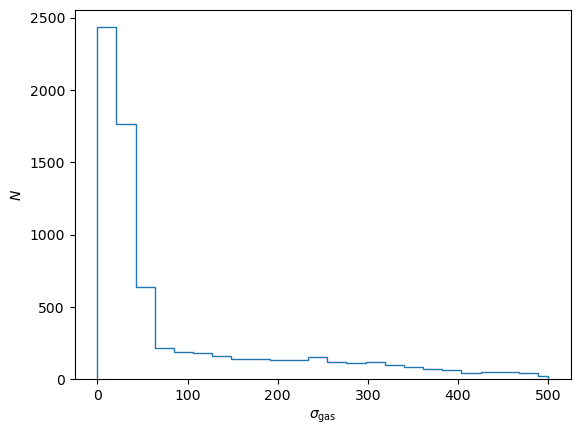

In [10]:
# Histograms showing the distribution in velocity dispersion
import matplotlib.pyplot as plt
from astropy.visualization import hist
fig, ax = plt.subplots(nrows=1, ncols=1)
hist(df[f"sigma_gas (component 1)"].values, bins="scott", ax=ax, range=(0, 500), density=False, histtype="step")
ax.set_xlabel(r"$\sigma_{\rm gas}$")
ax.set_ylabel(r"$N$")

You can also select a subset of the full data sample as follows:

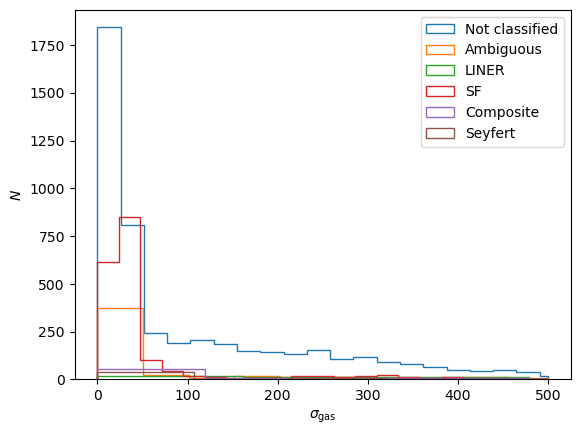

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for cat in df["BPT (total)"].unique():
    df_cat = df[df["BPT (total)"] == cat]
    hist(df_cat[f"sigma_gas (component 1)"].values, bins="scott", ax=ax, range=(0, 500), density=False, histtype="step", label=cat)
ax.set_xlabel(r"$\sigma_{\rm gas}$")
ax.set_ylabel(r"$N$")
ax.legend()

## Using `spaxelsleuth.plotting`
--- 
In the below cells, we will demonstrate how to use various functions in `spaxelsleuth.plotting` to make different kinds of plots useful for analysing the data set.

In [13]:
from spaxelsleuth.plotting.plottools import plot_empty_BPT_diagram, plot_BPT_lines
from spaxelsleuth.plotting.plotgalaxies import plot2dhistcontours, plot2dscatter

#### Plot the distribution of spaxels in the WHAN diagram
The WHAN diagram, developed by Cid Fernandes et al. (2010, 2011), plots the H$\alpha$ equivalent width (EW) against the [NII]6583Å/H$\alpha$ line ratio, and can be used to distinguish between emission by star formation, AGN and hot, low-mass evolved stars.

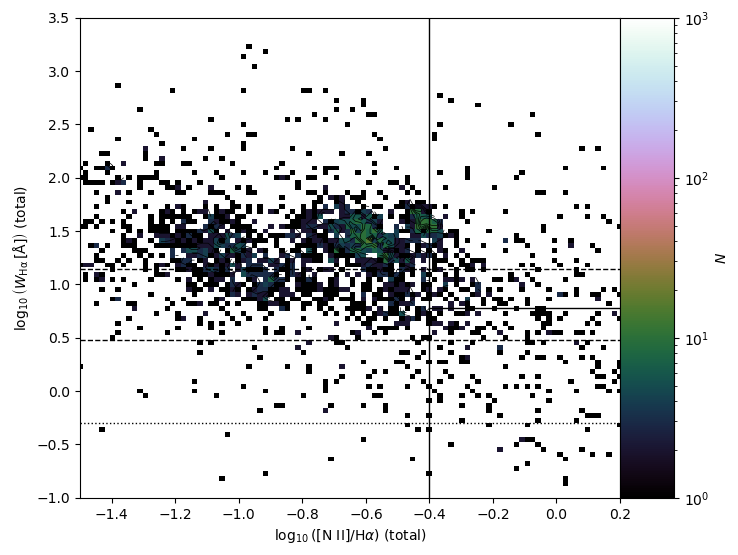

In [14]:
# Plot a 2D histogram showing the distribution of SAMI spaxels in the WHAN diagram
_ = plot2dhistcontours(df=df,
              col_x=f"log N2 (total)",
              col_y=f"log HALPHA EW (total)",
              col_z="count", log_z=True,
              plot_colorbar=True)

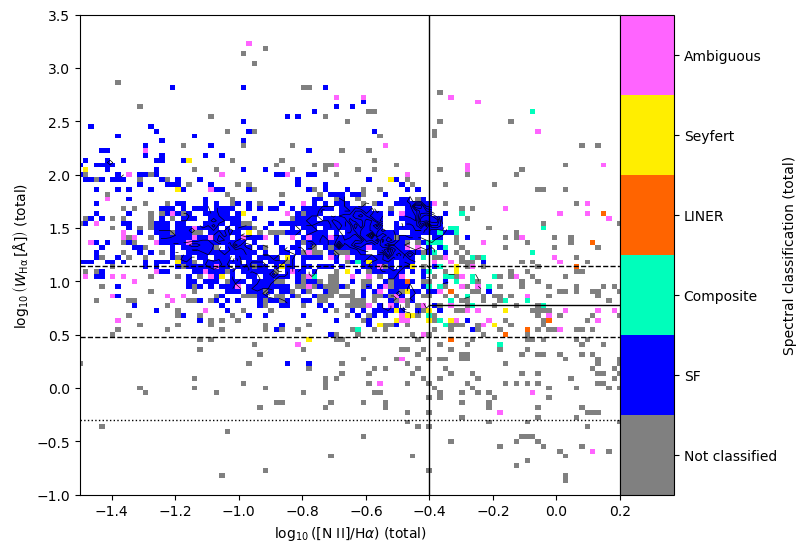

In [15]:
# Repeat the above, but colour by the median BPT classification
_ = plot2dhistcontours(df=df,
              col_x=f"log N2 (total)",
              col_y=f"log HALPHA EW (total)",
              col_z="BPT (total)", 
              plot_colorbar=True)

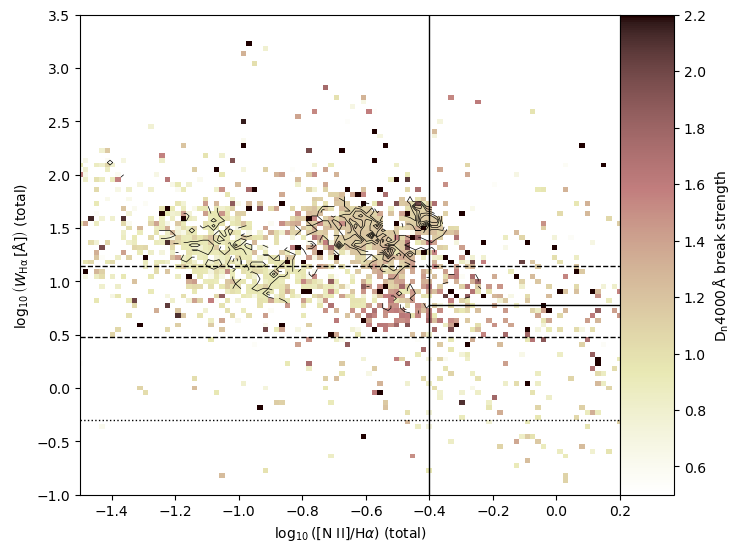

In [16]:
# Repeat the above, but colour by the D4000Å break strength
_ = plot2dhistcontours(df=df,
              col_x=f"log N2 (total)",
              col_y=f"log HALPHA EW (total)",
              col_z="D4000", 
              plot_colorbar=True)

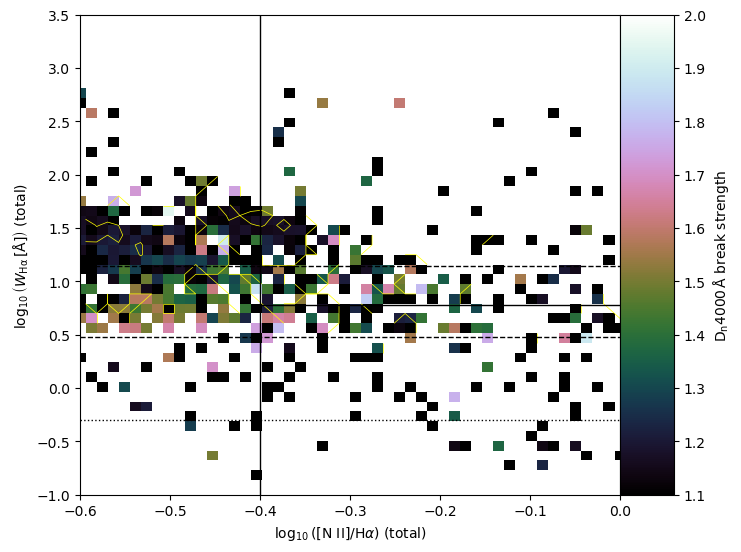

In [17]:
# If we like, we can use a different colourmap using the "cmap" keyword.
# The contour colours can also be changed using the "colors" keyword, and the levels can be changed using "levels".
# The axis limits can also be changed using the "xmin", "xmax", "ymin", "ymax" and "vmin", "vmax" keyword.
# We can also change the number of histogram bins using the "nbins" keyword.
import numpy as np
_ = plot2dhistcontours(df=df,
              col_x=f"log N2 (total)", xmin=-0.6, xmax=0.0,
              col_y=f"log HALPHA EW (total)", 
              col_z="D4000", vmin=1.1, vmax=2.0,
              nbins=50, 
              cmap="cubehelix", colors="yellow", levels=np.logspace(0, 4, 5),
              plot_colorbar=True)

#### Plot optical diagnostic ("BPT") diagrams for the full sample, showing the distribution of spaxels in all SAMI galaxies

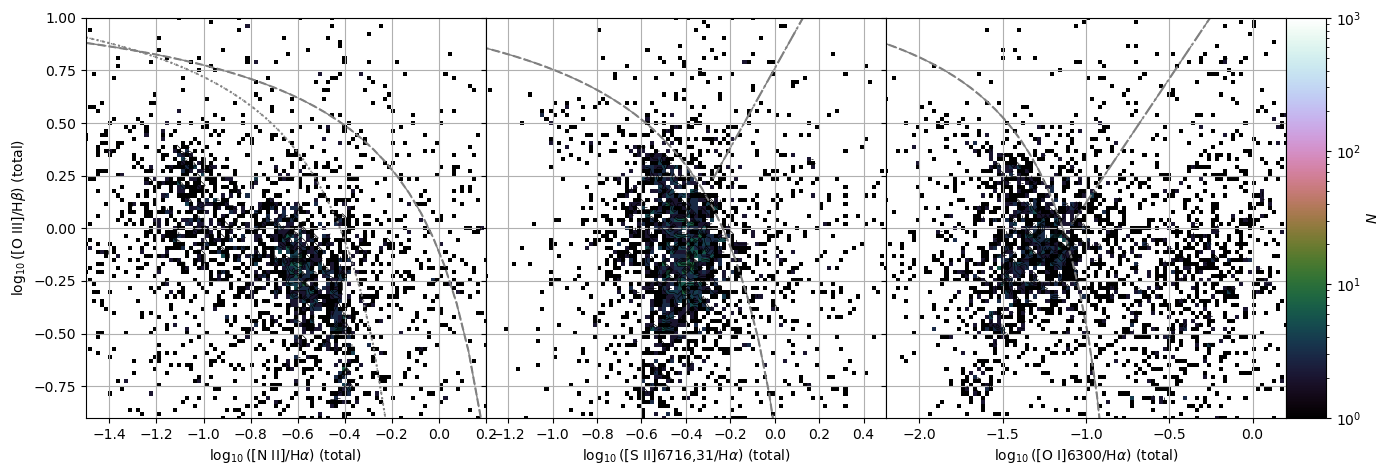

In [18]:
# Plot an empty BPT diagram
fig, axs_bpt = plot_empty_BPT_diagram(nrows=1)

# Plot 2D histograms showing the distribution of the entire sample
for cc, col_x in enumerate(["log N2", "log S2", "log O1"]):
    # Add BPT demarcation lines
    plot_BPT_lines(ax=axs_bpt[cc], col_x=col_x)    

    # Plot histograms showing distribution for whole sample
    _ = plot2dhistcontours(df=df,
                  col_x=f"{col_x} (total)",
                  col_y=f"log O3 (total)",
                  col_z="count", log_z=True,
                  ax=axs_bpt[cc],
                  cax=None,
                  plot_colorbar=True if cc==2 else False)

    if cc > 0:
        axs_bpt[cc].set_ylabel("")
    axs_bpt[cc].grid()

#### Repeat the above, but colour the histograms by $\sigma_{\rm gas}$

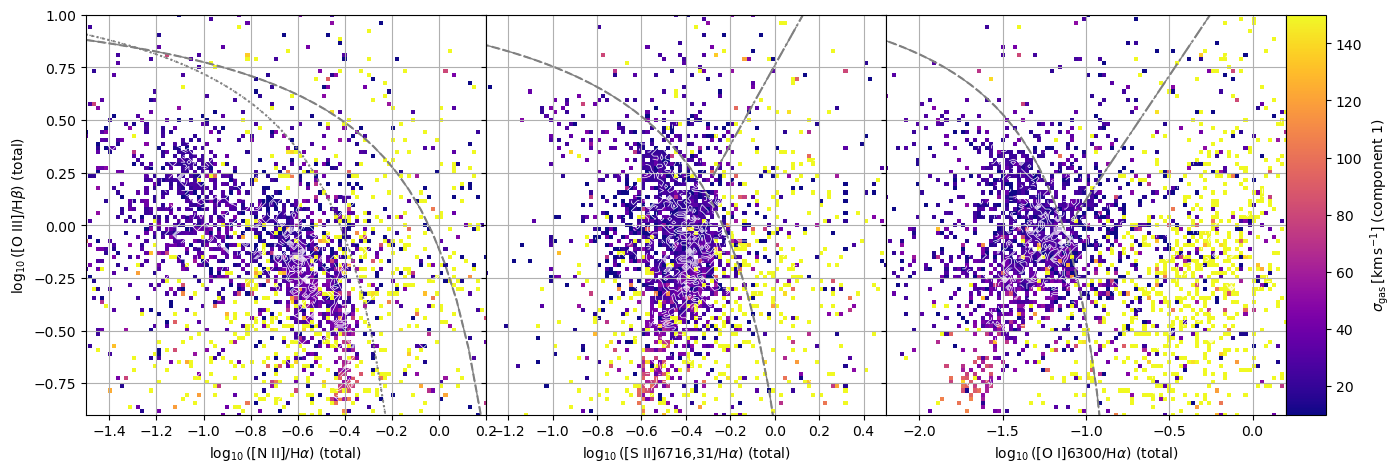

In [19]:
# Plot an empty BPT diagram
fig, axs_bpt = plot_empty_BPT_diagram(nrows=1)

# Plot 2D histograms showing the distribution of the entire sample
for cc, col_x in enumerate(["log N2", "log S2", "log O1"]):
    # Add BPT demarcation lines
    plot_BPT_lines(ax=axs_bpt[cc], col_x=col_x)    

    # Plot histograms showing distribution for whole sample
    _ = plot2dhistcontours(df=df,
                  col_x=f"{col_x} (total)",
                  col_y=f"log O3 (total)",
                  col_z="sigma_gas (component 1)", 
                  vmax=150,  # Tweak the z-axis scaling to bring out details 
                  ax=axs_bpt[cc],
                  cax=None, colors="white",
                  plot_colorbar=True if cc==2 else False)
    
    if cc > 0:
        axs_bpt[cc].set_ylabel("")
    axs_bpt[cc].grid()

## Using `spaxelsleuth.plotting` to plot individual galaxies
--- 
In the below cells, we will demonstrate how create plots based on individual SAMI galaxies using functions in `spaxelsleuth.plotting`.


In [20]:
gal = gals[2]

#### Plot 2D maps showing various quantities in this galaxy
Given a DataFrame corresponding to a single galaxy, `plot2dmap()` reconstructs a 2D image of a specified column (e.g., velocity dispersion) from the rows and plots it. 

plot2dmap.py (198) plot2dmap(): WARNING: 'bin_type' not specified - assuming 'default'
plot2dmap.py (224) plot2dmap(): WARNING: x0_px and y0_px were not found in the DataFrame so I am assuming their values from the shape of the data


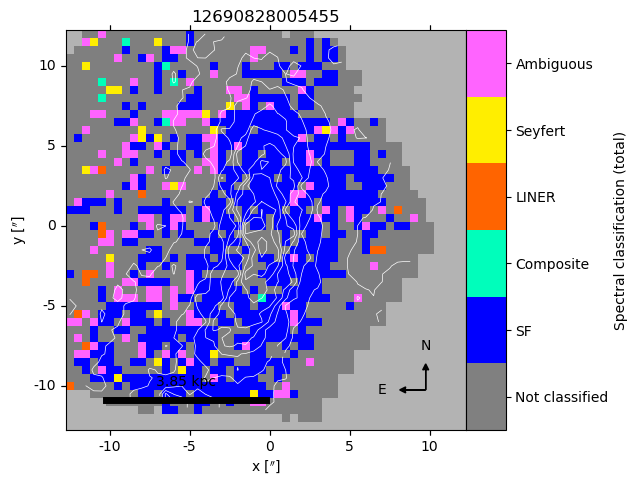

In [21]:
from spaxelsleuth.plotting.plot2dmap import plot2dmap
fig, ax = plot2dmap(df=df, gal=gal, col_z="BPT (total)")

plot2dmap.py (198) plot2dmap(): WARNING: 'bin_type' not specified - assuming 'default'
plot2dmap.py (224) plot2dmap(): WARNING: x0_px and y0_px were not found in the DataFrame so I am assuming their values from the shape of the data


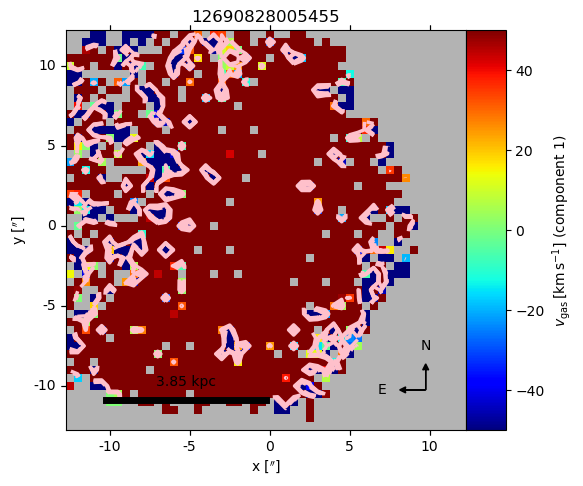

In [22]:
# Playing with input arguments 
# As in plot2dhistcontours, the maximum colour scaling can be set using "vmin" and "vmax" and the colourmap can be changed using "cmap". 
# The quantity that is used to plot contours can be set to any column in the DataFrame using "col_z_contours" and the colours and linewidths can be configured using "colours" and "linewidths".
_ = plot2dmap(df=df, gal=gal, col_z="v_gas (component 1)",
              cmap="jet", vmin=-50, vmax=+50,
              col_z_contours="v_gas (component 1)", levels=[-40, -20, 0, 20, 40], colors="pink", linewidths=2.5)


#### Scatter plots 
Create a BPT diagram with 2D histograms and contours showing the distribution in the full sample, with the data points from this galaxy overlaid on top using a scatter plot.

logger.py (181) _showwarning(): WARNING: /home/u5708159/.conda/envs/py310/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])

logger.py (181) _showwarning(): WARNING: /home/u5708159/.conda/envs/py310/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])

logger.py (181) _showwarning(): WARNING: /home/u5708159/.conda/envs/py310/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])

logger.py (181) _showwarning(): WARNING: /home/u5708159/.conda/envs/py310/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])

logger.py (181) _showwarning(): WARNING: /home/u5708159/.conda/envs/py310/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1103

[Text(0, 0.5, ''), Text(0, 0.5, '')]

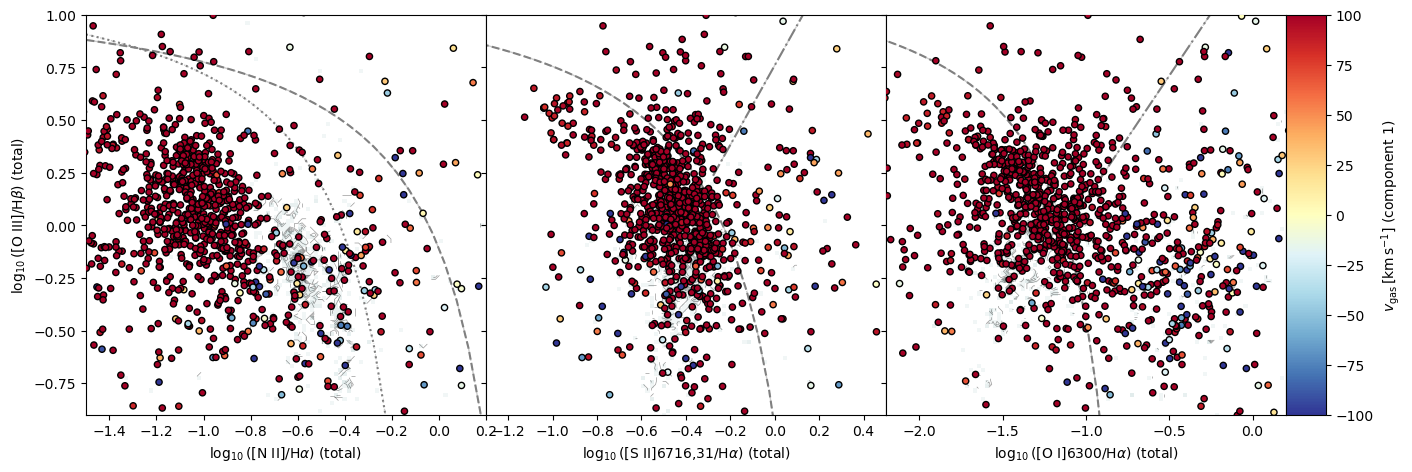

In [23]:
# Plot an empty BPT diagram
fig, axs_bpt = plot_empty_BPT_diagram(nrows=1)

# Plot 2D histograms showing the distribution of the entire sample
for cc, col_x in enumerate(["log N2", "log S2", "log O1"]):
    # Add BPT demarcation lines
    plot_BPT_lines(ax=axs_bpt[cc], col_x=col_x)    

    # Plot histograms showing distribution for whole sample
    _ = plot2dhistcontours(df=df,
                  col_x=f"{col_x} (total)",
                  col_y=f"log O3 (total)",
                  col_z="count", log_z=True,
                  cmap="bone_r", alpha=0.4,
                  ax=axs_bpt[cc],
                  plot_colorbar=False)
    
    # Scatter plot for this galaxy
    _ = plot2dscatter(df=df, gal=gal, 
                      col_x=f"{col_x} (total)",
                      col_y=f"log O3 (total)",
                      col_z=f"v_gas (component 1)",
                      ax=axs_bpt[cc],
                      vmin=-100, vmax=+100,
                      plot_colorbar=True if cc==2 else False)
    
# Turn of y-axis labels 
[ax.set_ylabel("") for ax in axs_bpt[1:]]